# K-means

内容安排：
1. K-means
2. 二分 K-means
3. 示例

## 1. K-means

**K-means 算法过程**：
1. 随机生成 k 个簇质心
2. 计算每个点到 k 个簇质心的距离
3. 每个点会被分配到距其最近的簇质心
4. 基于新分配到簇的点更新簇质心
5. 重复 2，3，4 直至所有簇质心不再改变

**伪代码**：

```
创建 k 个点作为初始簇质心（一般是随机选择）
当任一点的簇分配结果发生改变时:
    对数据集中每个点：
        对每个簇：
            计算该点与簇中心的距离
        将点分配到距其最近的簇
    对每个簇，计算簇中所有点的均值并将均值作为新质心
```

**初始化簇质心的细节：随机簇质心必须要在整个数据集的边界之内。**这可以通过找到数据集每个特征的最小、最大值，然后生成 0 到 1.0 之间的随机数乘以取值范围加上最小值，以便确保随机点在数据的边界之内。

**评价聚类效果**：误差平方和(SSE)。其中，误差平方是指点到簇质心的距离平方值。

In [21]:
import numpy as np
import random

def dist_eclud(vec0, vec1):
    '''
    计算两个向量的欧氏距离
    :param vec0: [np.array(1,n)] 
    :param vec1: [np.array(1,n)]
    :return : [float] 距离值
    '''
    assert(vec0.shape == vec1.shape)
    return float(np.sqrt(np.sum(np.power(vec0-vec1, 2))))

def init_random(dataset, k):
    '''
    随机初始化 k 个簇质心
    :param dataset: [np.array(m,n)] 数据集
    :param k: [int] 
    :return : [np.array(k,n)] k 个簇质心
    '''
    n = dataset.shape[1]
    centroids = np.zeros((k,n))
    for i in range(n):
        feature_min = dataset[:,i].min()
        feature_range = float(dataset[:,i].max() - feature_min)
        centroids[:,i] = feature_min + feature_range * np.random.rand(k,)
    return centroids

def kmeans(dataset, k, cal_dist=dist_eclud, init_cen=init_random):
    '''
    k-means 算法
    :param dataset: [np.array(m,n)] 数据集
    :param k: [int] 簇的数量
    :param cal_dist: [function] 计算距离的方法
    :param init_cen: [function] 初始化质心的方法
    :return : [np.array(k,n)] centroids k 个簇质心组成的列表
              [np.array(m,2)] cluster_assment 每个点的分配结果和到质心的距离
    '''
    m = dataset.shape[0]
    cluster_assment = np.zeros((m,2))  # 记录每个数据点的分配情况，第 1 列是分配到的簇编号，第 2 列是到簇的距离
    # 1. 创建 k 个点作为初始簇质心（一般是随机选择）
    centroids = init_cen(dataset, k)  # k 个簇质心组成的列表
    change_flag = True  # 是否发生改变的标记
    # 2. 当任一点的簇分配结果发生改变时:
    while change_flag:
        change_flag = False
        # 3. 对数据集中每个点
        for i in range(m):
            min_dist = float('inf')
            min_cluster = -1
            # 4. 对每个簇：
            for j in range(k):
                # 5. 计算该点与簇中心的距离
                dist = cal_dist(dataset[i,:], centroids[j,:])
                if dist < min_dist:
                    min_dist = dist
                    min_cluster = j
            if cluster_assment[i,0] != min_cluster:
                change_flag = True
            # 6. 将点分配到距其最近的簇
            cluster_assment[i, :] = min_cluster, min_dist**2
        print(centroids)
        # 7. 更新簇质心
        for i in range(k):
            all_point = dataset[np.nonzero(cluster_assment[:,0] == i)[0]]  # 第 i 个簇的所有点
            centroids[i, :] = np.mean(all_point, axis=0)
            
    return centroids, cluster_assment

def load_data(filename):
    dataset = []
    fr = open(filename)
    for line in fr.readlines():
        line = line.strip().split('\t')
        dataset.append(list(map(float, line)))
    return np.array(dataset)

dataset = load_data('./dataset/testSet.txt')
centroids, cluster_assment = kmeans(dataset, 4)

[[-4.527291   -2.47182303]
 [-3.79308816  3.99216759]
 [-0.59659123 -4.21898411]
 [-2.72195624  1.58007286]]
[[-3.67966141 -2.77958   ]
 [-2.30657914  3.75024757]
 [ 2.21588922 -2.88365904]
 [ 0.58926633  2.77786003]]
[[-3.53973889 -2.89384326]
 [-2.64677572  2.78993217]
 [ 2.65077367 -2.79019029]
 [ 2.31553173  3.07737886]]
[[-3.53973889 -2.89384326]
 [-2.46154315  2.78737555]
 [ 2.65077367 -2.79019029]
 [ 2.6265299   3.10868015]]


**缺点**：

1. 初始的簇质心对算法影响很大。
2. 如果初始化没做好，容易达到局部最小


这图就是达到了局部最小 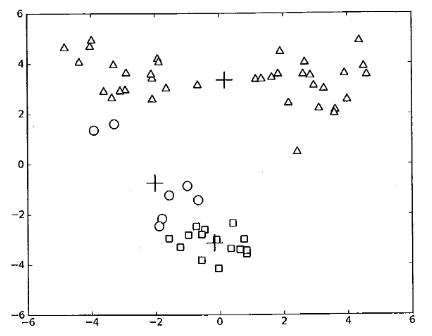

为了获得更好的聚类效果，使用 **二分 K-means**。

## 2. 二分 K-means

**二分 K-means 算法过程**： 
```
将所有点当作一个簇
当簇数目小于 k 时：
    对于每个簇：
        在该簇上进行 K-means聚类，其中 k=2
        计算将该簇一分为二之后的总误差=该簇一分为二后的sse+其他簇的sse
    选择使得误差最小的那个簇进行划分操作
```

In [27]:
def bin_kmeans(dataset, k, cal_dist=dist_eclud):
    '''
    二分 K-means 算法
    :param dataset: [np.array(m,n)] 数据集
    :param k: [int] 簇的数量
    :param cal_dist: [function] 计算距离的方法
    :return : [np.array(k,n)] centroids k 个簇质心组成的列表
              [np.array(m,2)] cluster_assment 每个点的分配结果和到质心的距离
    '''
    m = dataset.shape[0]
    cluster_assment = np.zeros((m,2))  # 记录每个数据点的分配情况，第 1 列是分配到的簇编号，第 2 列是到簇的距离
    # 1. 将所有点当作一个簇
    centroid0 = np.mean(dataset, axis=0)
    centroids = [centroid0.tolist()]
    for i in range(m):
        cluster_assment[i,1] = cal_dist(dataset[i,:], centroid0)**2
    # 2. 当簇数目小于 k 时：
    while len(centroids) < k:
        min_sse = float('inf')
        # 3. 对于每个簇：
        for i in range(len(centroids)):
            all_points =dataset[np.nonzero(cluster_assment[:,0]==i)[0],:]  # 第 i 个簇的所有点
            # 4. 在该簇上进行 K-means聚类，其中 k=2
            split_centroids, split_clustass = kmeans(all_points, 2)
            # 5. 计算将该簇一分为二之后的总误差
            split_sse = float(np.sum(split_clustass))  # 该簇一分为二后的sse
            nonsplit_sse = float(np.sum(cluster_assment[np.nonzero(cluster_assment[:,0]!=i)[0], 1]))  # 其他簇的sse
            print('split_sse', split_sse, 'nonsplit_sse', nonsplit_sse)
            if (split_sse + nonsplit_sse) < min_sse:
                min_sse = split_sse + nonsplit_sse
                best_centindex_tosplit = i  # 记录当前最好的切分簇
                best_new_cent = split_centroids  # 切分后簇的质心
                best_clustass = split_clustass.copy()  # 最好的切分后的每个点的sse
        print('the best cent to split', best_centindex_tosplit)
        print('the len of bestClustAss', len(best_clustass))
        # 4. 选择使得误差最小的那个簇进行划分操作
        centroids[best_centindex_tosplit] = best_new_cent[0,:].tolist()  # 将切分前的簇用切分后其中一个簇替换掉
        centroids.append(best_new_cent[1,:].tolist())  # 再将另外一个簇加入进去
        # 更新切分簇的所有点的 sse 比较麻烦
        best_clustass[np.nonzero(best_clustass[:,0]==1)[0], 0] = len(centroids)-1  # 上一行代码有关
        best_clustass[np.nonzero(best_clustass[:,0]==0)[0], 0] = best_centindex_tosplit
        cluster_assment[np.nonzero(cluster_assment[:,0] == best_centindex_tosplit)[0], :] = best_clustass
    
    return np.array(centroids), cluster_assment

dataset = load_data('./dataset/testSet2.txt')
centroids, cluster_assment = bin_kmeans(dataset, 3)
print(centroids)

[[ 3.47591954 -1.55345485]
 [-2.54148564  0.01490785]]
[[ 2.30597369  1.13269846]
 [-2.04172591  1.29616609]]
[[ 2.31558604  1.45114389]
 [-2.18133903  1.04057339]]
[[ 2.48778216  1.86902192]
 [-2.04736911  0.76555026]]
[[ 2.93386365  3.12782785]
 [-1.70351595  0.27408125]]
split_sse 581.2976292649145 nonsplit_sse 0.0
the best cent to split 0
the len of bestClustAss 60
[[2.40828607 0.78971361]
 [3.45240535 3.84330338]]
[[2.8348345  1.74564425]
 [2.95862094 3.47337375]]
[[3.1604785  1.93671333]
 [2.836743   3.6383055 ]]
split_sse 40.928372264482334 nonsplit_sse 501.7683305828214
[[ 0.4779724  -2.52105938]
 [-3.39182913  2.29605555]]
[[-0.45965615 -2.7782156 ]
 [-2.94737575  3.3263781 ]]
split_sse 87.2202000797829 nonsplit_sse 39.52929868209309
the best cent to split 1
the len of bestClustAss 40
[[ 2.93386365  3.12782785]
 [-0.45965615 -2.7782156 ]
 [-2.94737575  3.3263781 ]]
